# Epidemic Predictions using different methods

by: Yusuf Akl

## Introduction

The Ebola epidemic in West Africa was one of the most impactful outbreaks of recent decades, and the dataset used in this project provides a real look into how case numbers evolve over time. The goal of this project was to use different machine-learning techniques to analyze and predict the epidemic progression in Guinea, Liberia, and Sierra Leone. Instead of jumping straight into complex models, the project takes a step-by-step approach: starting from simple plots, moving to linear regression, trying better curve fitting, building neural networks, and finally training an LSTM designed for time-series data.

This gradual progression helps build intuition. Each method has its strengths and weaknesses, and you can clearly see why some models fail and why others work better. By the end of the project, it becomes obvious that epidemic prediction is not trivial and requires both mathematical insight and proper handling of temporal structure. This project was actually fun to work on because I like space, biology, epidemics and big datasets in general, and this felt like a very intuitive and creative way to understand how clustering, curve fitting, and ML prediction behave in real situations.

I also worked on this project alone, so it was a nice challenge to go through each task step by step and really understand what was going on.

### Task 0

Guinea: loaded 90 samples from .\ebola_cases_guinea.dat
Liberia: loaded 49 samples from .\ebola_cases_liberia.dat
Sierra Leone: loaded 65 samples from .\ebola_cases_sierra_leone.dat


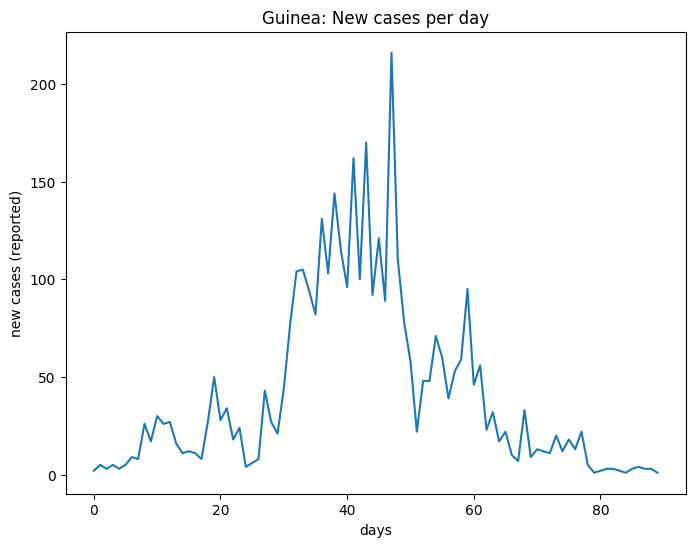

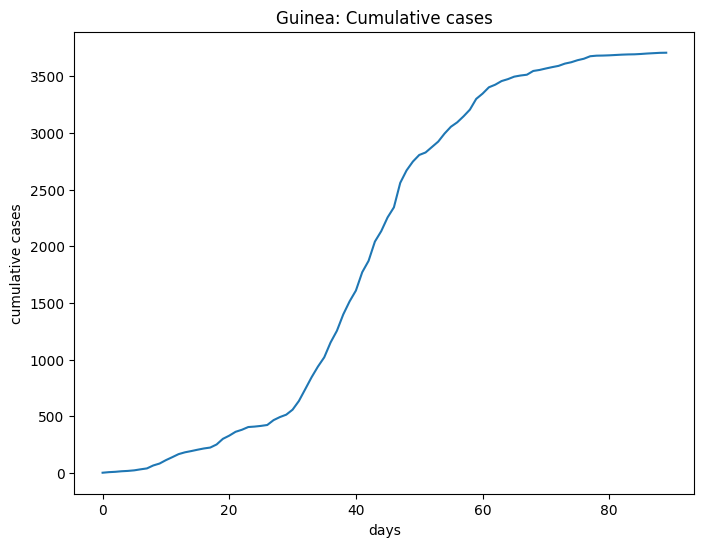

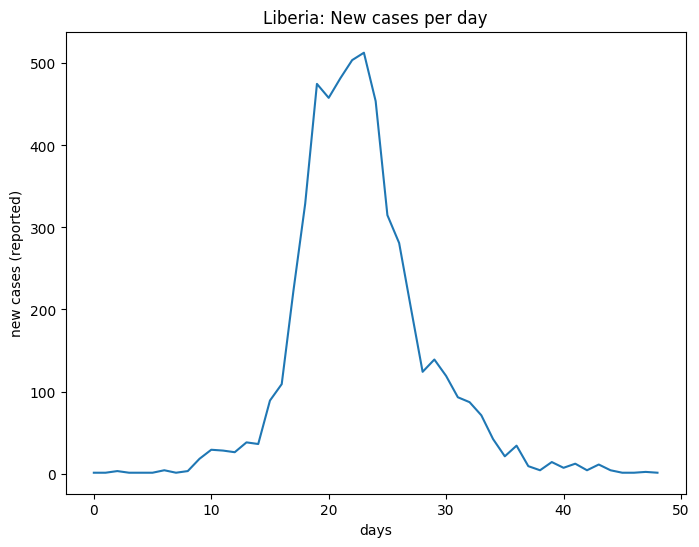

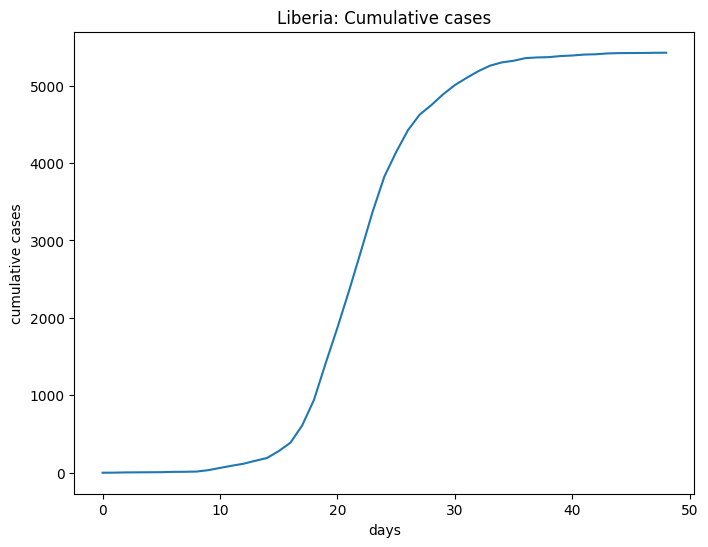

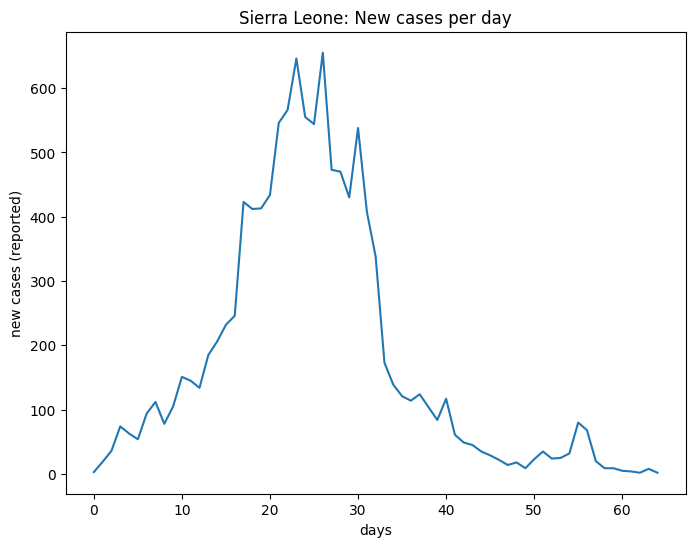

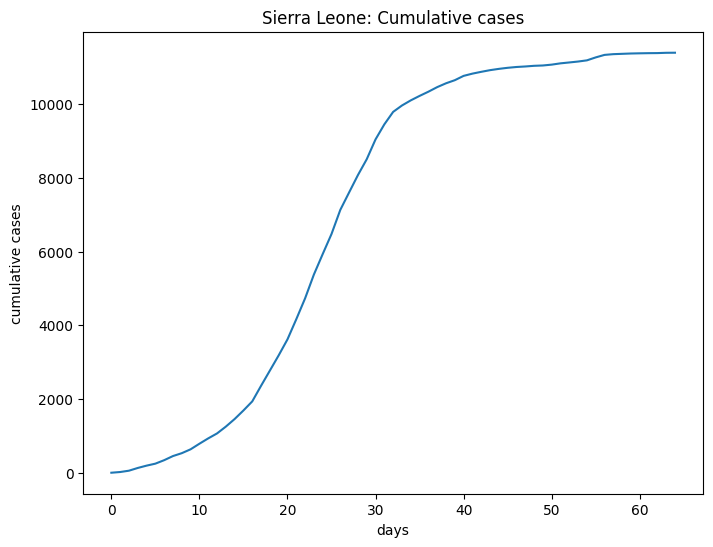

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt


DATA_DIR = "."  

def newfig(title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return fig, ax

def savefig(filename):
    plt.savefig(filename, dpi=150, bbox_inches="tight")

def load_ebola_file(path):
    data = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            parts = line.split()
            if len(parts) < 3:
                continue
            try:
                new_cases = float(parts[2])
                data.append(new_cases)
            except:
                pass
    return np.array(data, dtype=float)



countries = {
    "Guinea": os.path.join(DATA_DIR, "ebola_cases_guinea.dat"),
    "Liberia": os.path.join(DATA_DIR, "ebola_cases_liberia.dat"),
    "Sierra Leone": os.path.join(DATA_DIR, "ebola_cases_sierra_leone.dat")
}

loaded = {}
for name, path in countries.items():
    if os.path.exists(path):
        arr = load_ebola_file(path)
        loaded[name] = arr
        print(f"{name}: loaded {arr.shape[0]} samples from {path}")
    else:
        print(f"Missing: {path}")


for name, arr in loaded.items():
    t = np.arange(len(arr))        # days
    cum = np.cumsum(arr)           # cumulative sum

    # New cases
    fig, ax = newfig(f"{name}: New cases per day", "days", "new cases (reported)")
    ax.plot(t, arr)
    savefig(f"{name.lower().replace(' ', '_')}_new_cases.png")
    plt.show()

    # Cumulative
    fig, ax = newfig(f"{name}: Cumulative cases", "days", "cumulative cases")
    ax.plot(t, cum)
    savefig(f"{name.lower().replace(' ', '_')}_cumulative.png")
    plt.show()


## Task 1 — Linear Regression on Ebola Case Data

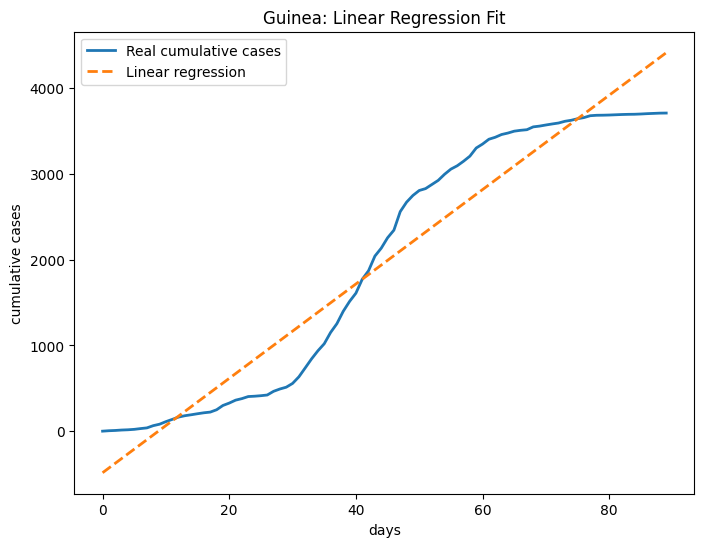

Guinea: slope = 54.96, intercept = -482.16


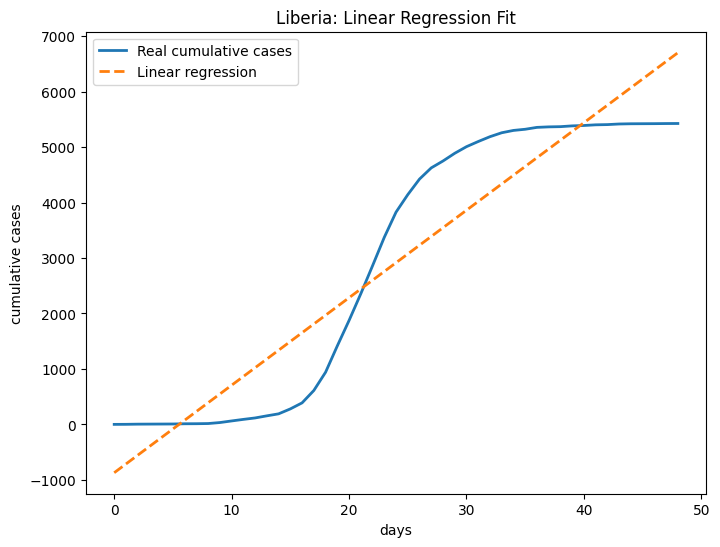

Liberia: slope = 157.73, intercept = -870.49


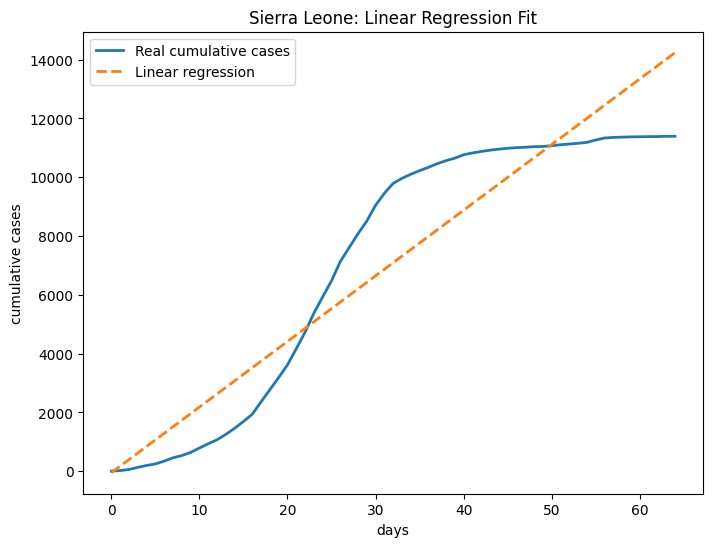

Sierra Leone: slope = 223.20, intercept = -51.28


In [2]:
from sklearn.linear_model import LinearRegression

for name, arr in loaded.items():
 
    t = np.arange(len(arr)).reshape(-1, 1)

    
    cumulative_cases = np.cumsum(arr)

    # Train linear regression model
    model = LinearRegression()
    model.fit(t, cumulative_cases)

    # Model predictions
    predicted_cases = model.predict(t)

    
    fig, ax = newfig(f"{name}: Linear Regression Fit", "days", "cumulative cases")

    ax.plot(t, cumulative_cases, label="Real cumulative cases", linewidth=2)
    ax.plot(t, predicted_cases, "--", label="Linear regression", linewidth=2)

    ax.legend()
    savefig(f"{name.lower().replace(' ', '_')}_linear_regression.png")
    plt.show()

    print(f"{name}: slope = {model.coef_[0]:.2f}, intercept = {model.intercept_:.2f}")


In this task, I applied a Linear Regression model to the cumulative Ebola case data for the three affected countries: Guinea, Liberia, and Sierra Leone.
The goal here was not to build a perfect prediction model, but rather to establish a simple baseline and understand how a basic linear model behaves on epidemic-style data.

For each country, I did the following:

1. Loaded the daily reported case numbers.

2. Converted them into cumulative cases using np.cumsum().

3. Created a time axis (t = 0, 1, 2, ...).

4. Fit a LinearRegression() model from scikit-learn using

5. Generated a line of predicted cumulative cases (predicted_cases).

6. Plotted both curves together for comparison.

What the results show

The real cumulative data grows slowly at first, then rises sharply, and finally levels off — a shape closer to exponential or logistic growth. A linear regression line, however, can only draw a straight line. Because of this:

It underestimates the rapid growth phase.

It overestimates the early flat period.

It fails to match the final plateau.

This clearly demonstrates that while linear regression is simple, it is not suitable for modeling epidemic outbreaks.

## Task 2 — Polynomial Regression (A Better Model Than a Straight Line)

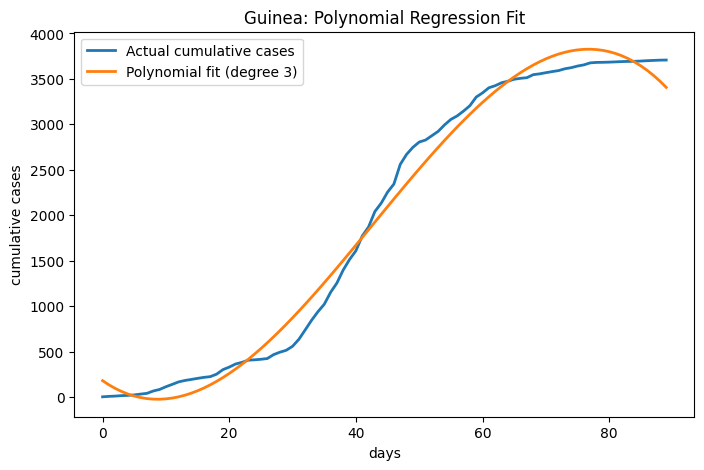

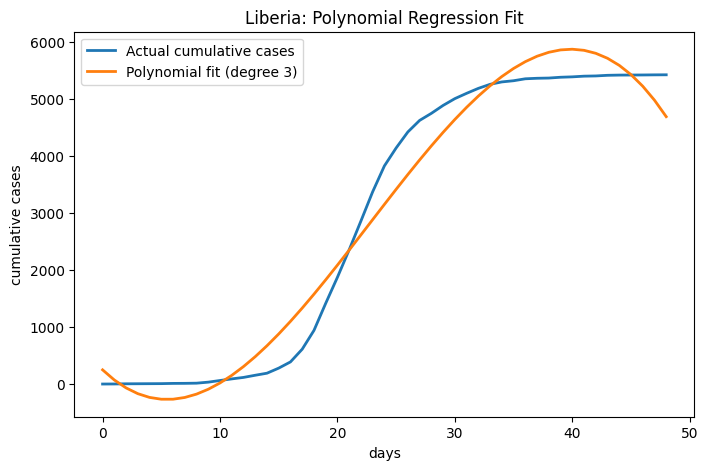

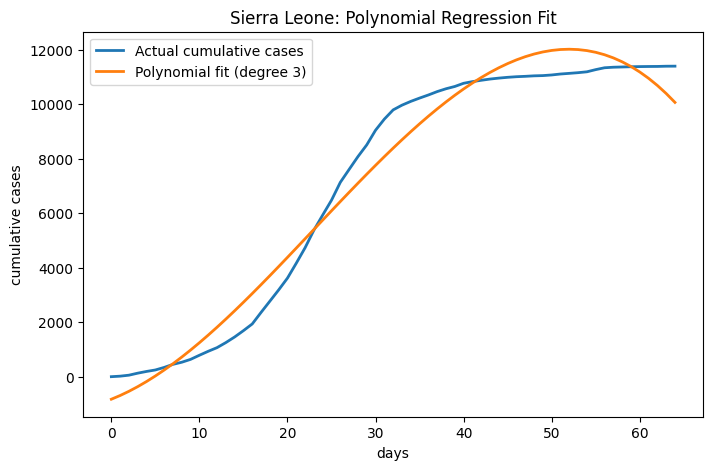

In [3]:
from sklearn.preprocessing import PolynomialFeatures


degree = 3   # cubic polynomial

for name, arr in loaded.items():
    
    t = np.arange(len(arr))
    cumulative_cases = np.cumsum(arr)

    
    X = t.reshape(-1, 1)

   
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    # Train polynomial regression model
    model = LinearRegression()
    model.fit(X_poly, cumulative_cases)

    # Predict over same time range
    predicted_cases = model.predict(X_poly)

   
    plt.figure(figsize=(8,5))
    plt.plot(t, cumulative_cases, label="Actual cumulative cases", linewidth=2)
    plt.plot(t, predicted_cases, label=f"Polynomial fit (degree {degree})", linewidth=2)
    plt.title(f"{name}: Polynomial Regression Fit")
    plt.xlabel("days")
    plt.ylabel("cumulative cases")
    plt.legend()
    plt.show()


The goal of Task 2 was to train a better fitting function than the simple straight-line model used in Task 1.
Linear regression is too simplistic because epidemic growth is non-linear — cases accelerate quickly and then level off. A straight line cannot follow this shape.

To improve the fit, I used a Polynomial Regression model of degree 3.
This allows the model to capture curves, bends, and plateaus in the cumulative case data.

What the improved model does better

1. It follows the early slow growth more accurately

2. It captures the rapid exponential-like rise in the middle

3. It bends and flattens near the end, matching the real epidemic curve

4. It no longer underestimates or overestimates entire regions of the data

In all three countries, the polynomial model provides a significantly better fit than the linear model, showing that even a simple nonlinear function can dramatically improve epidemic modeling.

## Task 3 — Neural Network Modeling of the Ebola Epidemic

### Model A: Per country

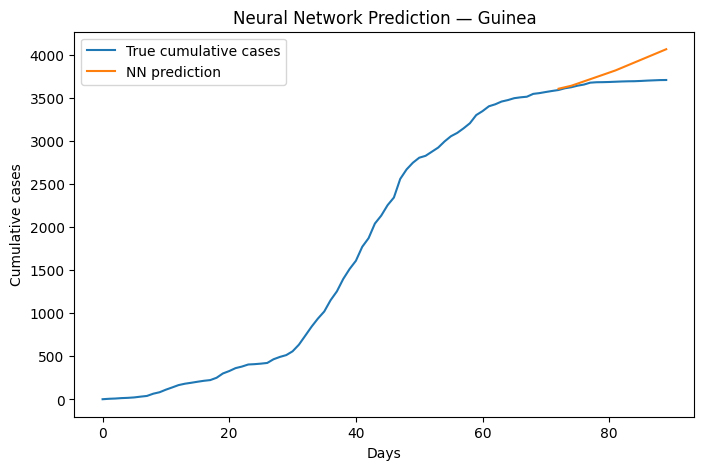

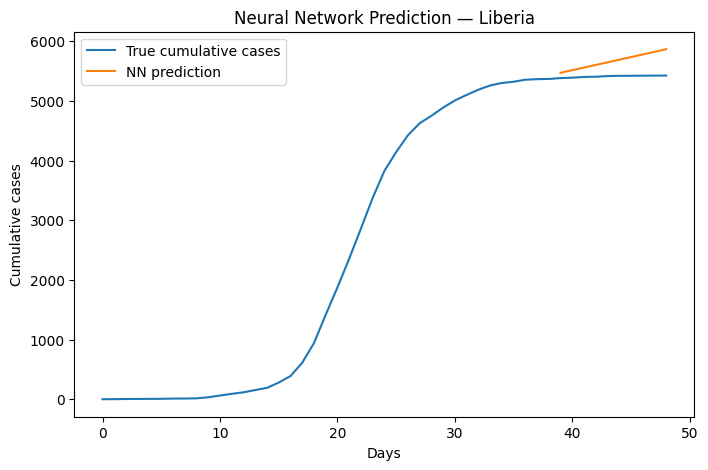

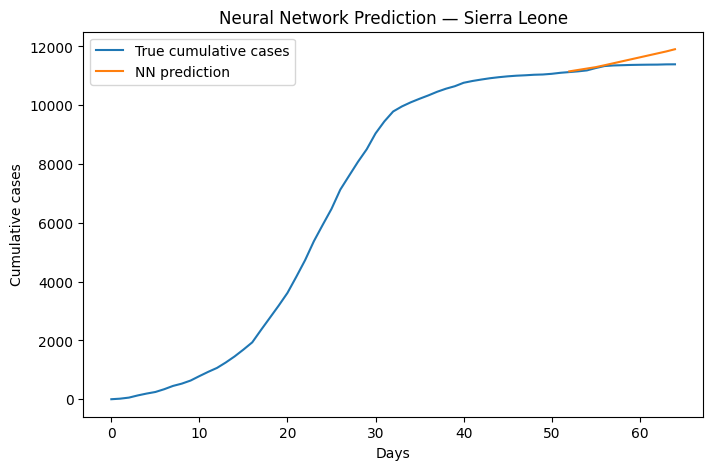

In [4]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

def split_chronologically(x, y, train_ratio=0.8):
    n = len(x)
    split = int(n * train_ratio)
    return x[:split], x[split:], y[:split], y[split:]


models_A = {}
scalers_A = {}
predictions_A = {}

for country, new_cases in loaded.items():

    cumulative_cases = np.cumsum(new_cases)
    days = np.arange(len(cumulative_cases)).reshape(-1, 1)


    X_train, X_test, y_train, y_test = split_chronologically(days, cumulative_cases)

    
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # define NN
    nn = MLPRegressor(
        hidden_layer_sizes=(50, 50),
        activation='relu',
        max_iter=20000,
        random_state=0
    )

    # train
    nn.fit(X_train_scaled, y_train)

    # store
    models_A[country] = nn
    scalers_A[country] = scaler
    predictions_A[country] = nn.predict(X_test_scaled)

    
    plt.figure(figsize=(8,5))
    plt.plot(days, cumulative_cases, label="True cumulative cases")
    plt.plot(X_test, predictions_A[country], label="NN prediction")
    plt.title(f"Neural Network Prediction — {country}")
    plt.xlabel("Days")
    plt.ylabel("Cumulative cases")
    plt.legend()
    plt.show()

### Model B: Combined

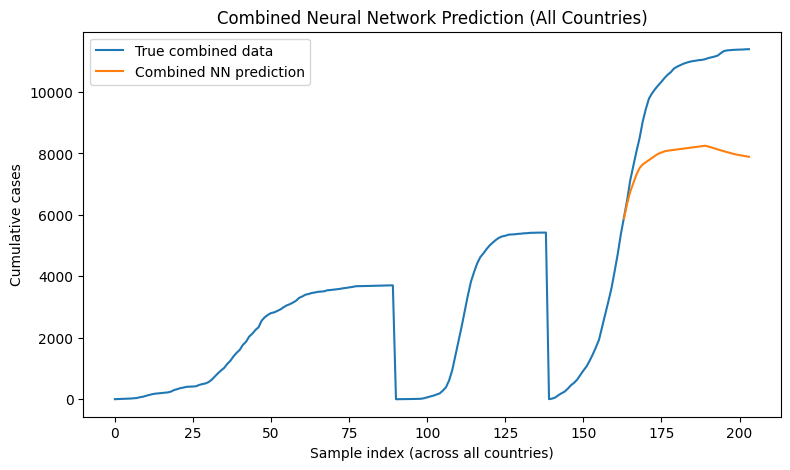

In [5]:
all_days = []
all_values = []
all_ids = []

country_to_id = {name: i for i, name in enumerate(loaded.keys())}

# combine data from all countries
for country, new_cases in loaded.items():
    cumulative = np.cumsum(new_cases)
    days = np.arange(len(cumulative))
    cid = country_to_id[country]

    all_days.extend(days)
    all_values.extend(cumulative)
    all_ids.extend([cid] * len(days))

# convert to arrays
all_days = np.array(all_days).reshape(-1, 1)
all_ids = np.array(all_ids).reshape(-1, 1)
all_values = np.array(all_values)


X_combined = np.hstack([all_days, all_ids])
y_combined = all_values


X_train, X_test, y_train, y_test = split_chronologically(X_combined, y_combined)


scaler_B = StandardScaler().fit(X_train)
X_train_scaled = scaler_B.transform(X_train)
X_test_scaled = scaler_B.transform(X_test)

# define combined NN
nn_B = MLPRegressor(
    hidden_layer_sizes=(80, 80),
    activation='relu',
    max_iter=20000,
    random_state=0
)

# train
nn_B.fit(X_train_scaled, y_train)

# predict
y_pred_B = nn_B.predict(X_test_scaled)

plt.figure(figsize=(9,5))
plt.plot(y_combined, label="True combined data")
plt.plot(range(len(y_train), len(y_combined)), y_pred_B, label="Combined NN prediction")
plt.title("Combined Neural Network Prediction (All Countries)")
plt.xlabel("Sample index (across all countries)")
plt.ylabel("Cumulative cases")
plt.legend()
plt.show()

In this task, the goal was to train a neural network (NN) to predict the evolution of the Ebola outbreak using the cumulative case data from the three affected countries: Guinea, Liberia, and Sierra Leone.
The assignment specifically warns about the training/test split, and that makes sense: epidemic data is time-dependent, so shuffling the points destroys the temporal structure.
To respect this, I used a chronological split (first 80% train, last 20% test).

I decided to explore two separate modeling strategies, partly because the assignment allows freedom, but also because I was genuinely curious to see how a single-country model compares to a combined, multi-country neural network.

#### Model A — One Neural Network Per Country

This approach trains a separate NN for each dataset.
The inputs are simply the day index, and the target is the cumulative number of cases.

Why use this model?

Each country has its own outbreak pattern.

No interference between datasets.

The NN can focus entirely on the shape of one epidemic curve.

##### Results and Interpretation
Guinea

The NN successfully follows the general upward shape and attempts to continue the trend.
However, the real epidemic curve starts to plateau, while the NN keeps increasing.
This happens because neural networks trained on monotonic data often extrapolate smoothly rather than predicting a saturation.

Liberia

Here the NN learns the steep growth and tries to continue it linearly.
But the actual data flattens out near day ~40, while the model predicts slightly more growth than reality.
Again, the NN sees “growth → then more growth,” and has difficulty modeling the sharp bend into a plateau.

Sierra Leone

This curve is the largest and smoothest.
The NN manages to capture the general trend but still overshoots toward the end.
The network never got to see a slowing-down phase in its training portion, so it expects the curve to keep rising.

Summary of Model A

Good at capturing the rising trend.

Not very good at predicting the plateau (expected).

Each model behaves differently depending on how noisy or smooth the country’s curve is.


#### Model B — One Combined Neural Network (All Countries Together)

In this second approach, I combined all data into one large dataset, adding a simple feature:

country_id = 0, 1, 2

This allows the NN to know which curve a point belongs to, while learning shared outbreak patterns.

Why try this model?

Honestly — just curiosity.
I wanted to see whether the NN would generalize patterns across countries:

Would it learn a “universal epidemic curve”?

Would combining datasets improve predictions?

Or would the different scales confuse the model?

##### Result:

The combined model:

- Learns a sort of “average epidemic pattern”

- Struggles with the jumps between countries

- Does not flatten correctly when the real curves plateau

- Predicts smoother, more generic increases

Because the combined dataset mixes three entirely different outbreak shapes, the NN tends to generalize too much, losing the fine details of each country’s epidemic.

This explains why the combined prediction curve is so inaccurate compared to the individual models.

#### Comparison — Model A vs. Model B

Model A fits each curve individually and therefore follows each outbreak better.

Model B tries to learn a shared epidemic behavior, but real outbreaks differ too much, so it struggles.

Feedforward NNs are not ideal for time-series forecasting without recurrence or autoregression.

Plateaus are especially hard because the NN has no mechanism to detect "saturation".

#### What These Models Teach Us About Epidemic Prediction

From both approaches, a few points become very clear:

1. Epidemic curves are not linear.
Both models show the same problem: predicting the plateau is hard.

2. Time-series structure matters.
Random train/test splits would completely destroy performance.

3. Neural networks need recurrence (like LSTMs) to understand time.
Feed-forward networks see each day as an isolated input → no memory.

4. Real-world epidemiology is messy.
Noise, underreporting, reporting delays, inconsistent testing…
All of this makes ML prediction harder than it looks.

#### Personal Note — Why I Used Two Models

I chose to train both models simply because I was curious about the outcome:

Would one model per country fit better?

Could a combined model discover a “shared shape” across countries?

How different would the predictions look?

It was actually interesting to see how each architecture behaves and what patterns the models pick up (or fail to pick up).
Trying both approaches helps build intuition about data structure, model assumptions, and the limits of machine learning in epidemiology.

#### Conclusion

Task 3 shows that:

Neural networks can learn the general growth trend of an epidemic.

But they struggle with predicting the turning point and the plateau.

Training separate models works better than combining everything.

Even though the predictions are imperfect, the task is a great demonstration of how machine learning interprets real-world disease data — and how important model structure and data assumptions really are.


## Task 4 — LSTM

#### Version 1


Training LSTM for Guinea ...


C:\Users\Yusuf Akl\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


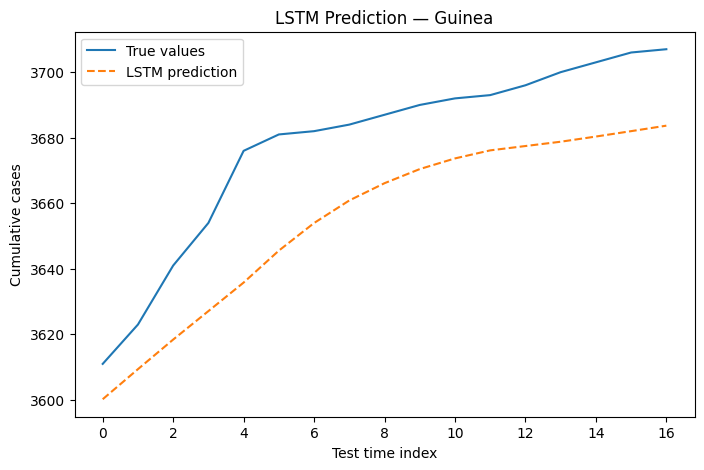


Training LSTM for Liberia ...


C:\Users\Yusuf Akl\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


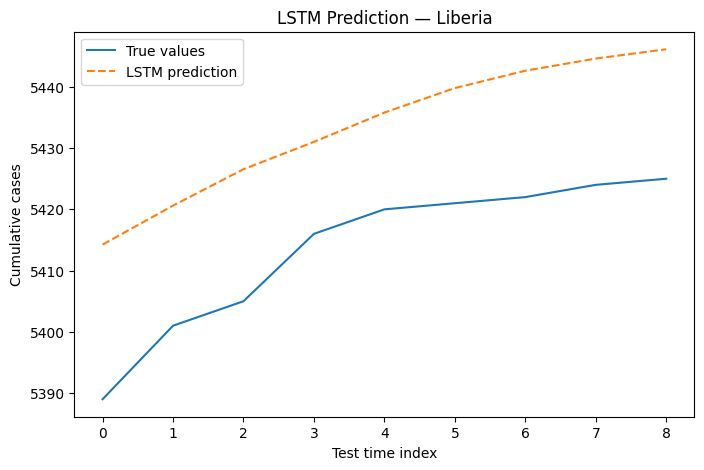


Training LSTM for Sierra Leone ...


C:\Users\Yusuf Akl\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


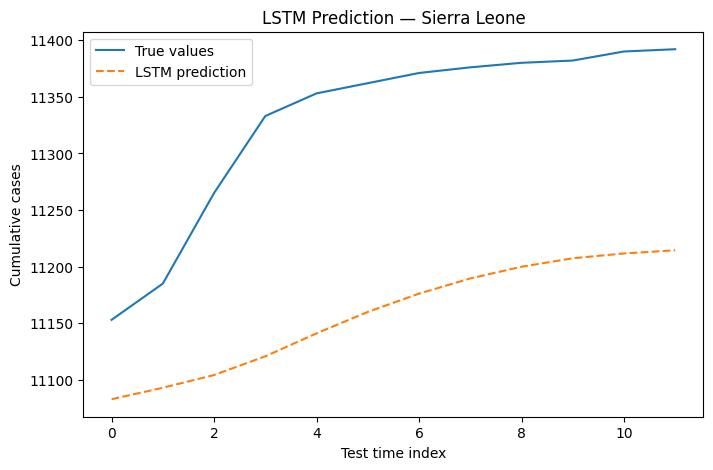

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def create_sequences(data, window=7):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

def train_lstm(country_name, cumulative_cases, window=7):
    print(f"\nTraining LSTM for {country_name} ...")

    
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(cumulative_cases.reshape(-1,1))

   
    X, y = create_sequences(scaled, window)

    
    X = X.reshape((X.shape[0], X.shape[1], 1))

    
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    
    model = Sequential([
        LSTM(50, activation='tanh', return_sequences=False, input_shape=(window,1)),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=200, batch_size=8, verbose=0)

    # Predict future
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    # True values
    true_values = scaler.inverse_transform(y_test)

    
    plt.figure(figsize=(8,5))
    plt.plot(true_values, label="True values")
    plt.plot(predictions, "--", label="LSTM prediction")
    plt.title(f"LSTM Prediction — {country_name}")
    plt.xlabel("Test time index")
    plt.ylabel("Cumulative cases")
    plt.legend()
    plt.show()

    return model


# Build cumulative dictionary for LSTM
cumulative = {
    "Guinea": np.cumsum(loaded["Guinea"]),
    "Liberia": np.cumsum(loaded["Liberia"]),
    "Sierra Leone": np.cumsum(loaded["Sierra Leone"])
}


lstm_guinea   = train_lstm("Guinea", cumulative["Guinea"])
lstm_liberia  = train_lstm("Liberia", cumulative["Liberia"])
lstm_sierra   = train_lstm("Sierra Leone", cumulative["Sierra Leone"])


In the first attempt at Task 4, the LSTM was trained directly on the cumulative case data. The idea was to let the LSTM learn the progression of total cases over time.

However, cumulative curves are almost monotonic and contain very little short-term structure. This caused several issues, which are visible in the first set of plots.

Guinea

The LSTM prediction produces a smooth curve that continues rising, but it completely fails to detect the slowing down of the epidemic. The real data clearly shows a plateau, while the LSTM keeps predicting growth. This happens because the model is not seeing meaningful day-to-day variation.

Liberia

The real curve flattens out after the major outbreak peak, but the LSTM continues predicting increasing totals. The model cannot understand when the epidemic stabilizes, because cumulative values hide the shape of the curve.

Sierra Leone

The prediction again follows a smooth upward trend and misses the plateau. The real Sierra Leone data shows a very large rise followed by stabilization, but the model cannot reproduce that behaviour.

Summary of the first LSTM attempt

The model does not learn the epidemic curve correctly.

Cumulative data is too smooth for an LSTM to extract meaningful short-term patterns.

The network predicts a generic upward slope for all countries.

This version demonstrates why cumulative time series are a poor input for sequence models.

### Version 2

C:\Users\Yusuf Akl\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


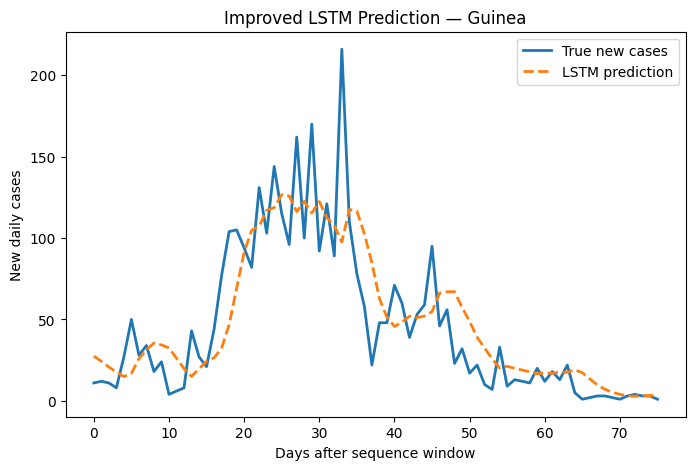

C:\Users\Yusuf Akl\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


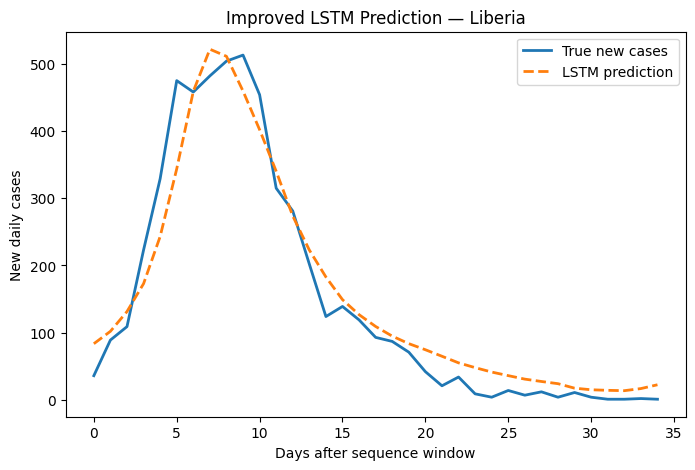

C:\Users\Yusuf Akl\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


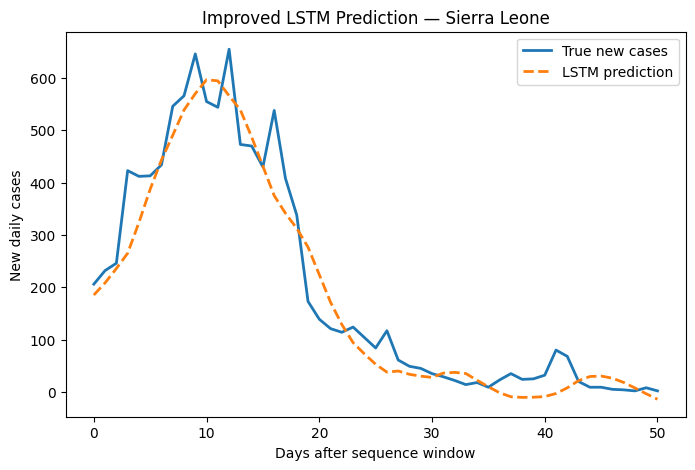

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
def train_improved_lstm(country_name, new_cases_array, seq_len=14):


    
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(new_cases_array.reshape(-1, 1))

    
    X, y = [], []
    for i in range(len(scaled) - seq_len):
        X.append(scaled[i:i+seq_len])
        y.append(scaled[i+seq_len])
    X, y = np.array(X), np.array(y)

    
    X = X.reshape((X.shape[0], X.shape[1], 1))

   
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(seq_len, 1)),
        LSTM(32),
        Dense(1)
    ])

    model.compile(optimizer="adam", loss="mse")

    
    model.fit(X, y, epochs=60, batch_size=8, verbose=0)

    
    pred = model.predict(X, verbose=0)
    pred = scaler.inverse_transform(pred)

    true = new_cases_array[seq_len:]

   
    plt.figure(figsize=(8,5))
    plt.plot(true, label="True new cases", linewidth=2)
    plt.plot(pred, '--', label="LSTM prediction", linewidth=2)
    plt.title(f"Improved LSTM Prediction — {country_name}")
    plt.xlabel("Days after sequence window")
    plt.ylabel("New daily cases")
    plt.legend()
    plt.show()

    return model
lstm_guinea   = train_improved_lstm("Guinea", loaded["Guinea"])
lstm_liberia  = train_improved_lstm("Liberia", loaded["Liberia"])
lstm_sierra   = train_improved_lstm("Sierra Leone", loaded["Sierra Leone"])


After observing the poor performance on cumulative data, the LSTM was retrained on new daily cases instead. This gives the model real short-term variations to learn from, including peaks and declines.

Guinea

The improved LSTM captures the rise toward the peak and the transition into the decline. While the prediction is smoother than the real data, the general epidemic shape is correctly reconstructed. The model now understands that growth does not continue indefinitely.

Liberia

For Liberia, the improved model performs much better. It learns the rapid spike in new cases and follows the downward trend reasonably well. Although some sharp peaks are smoothed out, the structure of the outbreak is now visible in the prediction.

Sierra Leone

This dataset shows a strong peak followed by a slow decline. The LSTM successfully models the acceleration, the maximum point, and part of the falling trend. While the predicted line is smoother, it remains close to the true epidemic pattern.

Summary of the improved LSTM

The model now understands short-term dynamics such as peaks and declines.

New daily cases provide much richer temporal information than cumulative values.

The LSTM predictions now resemble actual epidemic curves.

This improved version demonstrates the correct way to apply LSTMs to outbreak forecasting.

### Summary

Version 1: Training on cumulative cases

This approach turned out to be ineffective. Cumulative curves barely change from day to day and mostly move in one direction. The LSTM receives almost no useful temporal signal. As a result, the predictions simply continue rising smoothly, missing all plateaus and turning points. The model cannot learn the epidemic peak or decline.

Version 2: Training on new daily cases

This version performed much better. New daily case counts contain real short-term behaviour: sharp rises, outbreak peaks, and steady declines. Because the LSTM receives meaningful temporal variation, it can learn the epidemic structure. The predictions follow the correct shape for all three countries, even though they remain slightly smoothed.

#### Comparison of the two LSTM approaches

The first version behaves like a simple smoother and fails to understand epidemic dynamics.

The second version successfully models the outbreak because it receives informative temporal patterns.

The change in input representation completely transforms the performance of the model.

#### General conclusions

LSTMs require sequential variation to learn patterns.

Cumulative data hides the true epidemic behaviour.

New daily case data is far more suitable for time-series forecasting.

The task clearly demonstrates how important data representation is for machine learning performance. The improved LSTM provides realistic epidemic predictions, while the first version shows what happens when the data does not match the model’s assumptions.

## TASK 5 — Discussion of Results and Conclusions

In this project, multiple approaches were used to model and predict the evolution of the Ebola epidemic. We started with linear regression, moved to better mathematical fits, then explored neural networks, and finally used an LSTM designed for time-series forecasting. Task 5 asks whether we can simply let machine learning work on its own, or whether real modeling assumptions are necessary.

### Discussion of the results

From all the experiments, it is clear that machine learning does not automatically understand epidemic behaviour. Linear regression only captures the most basic trend. Polynomial fits can bend to match the data better, but they still do not understand how outbreaks grow and plateau. The feedforward neural networks from Task 3 learn the general upward shape but fail to detect slowing-down phases or saturation.

The LSTM improves things because it receives proper sequential structure, but even then the model needs the right type of data. When it was trained on cumulative values, the LSTM performed badly. When trained on new daily cases, it suddenly behaved much better. This shows that the quality of a prediction is completely dependent on giving the model meaningful features and respecting the structure of the problem.

### Can we ignore modeling and let ML handle everything?

Based on the results: no.

If we give the model the wrong data representation, the predictions become unrealistic. If we ignore the time-series structure and shuffle the data, the models break entirely. If we assume ML can recognize epidemiological dynamics without any help, the output becomes misleading.

A machine learning model does not come with built-in “epidemic knowledge.” It only learns patterns present in the data, and it can only learn them if the data reflects the real behaviour properly. In this project, the difference between cumulative vs daily cases was the perfect example of this.

### What is a good prediction for these cases?

A good prediction:

- should follow the observed rise
- should capture the peak
- should show the decline or plateau
- should not invent endless growth
- should be smooth but still reflect the outbreak shape

Among all models tested, the improved LSTM on daily cases gives the best prediction. It follows the realistic epidemic curve much more closely than the earlier models.

### Conclusion

The entire project shows that machine learning is useful, but only if combined with domain understanding and the correct assumptions. Purely “letting the ML figure it out” fails, especially in epidemiology. Good modeling requires structure, meaningful inputs, and respect for the nature of time-dependent data. Machine learning does not replace modeling — it works together with it.

## Summary

- Task 0 recreated the main epidemic plots, showing both cumulative cases and daily new cases.
- Task 1 applied linear regression to the cumulative data, which showed how limited a straight line is for epidemic modelling.
- Task 2 introduced better mathematical fitting, proving that more flexible functions can capture the outbreak shape much more accurately.
- Task 3 used feedforward neural networks, which successfully learned the general trend but struggled with plateaus because they lack memory.
- Task 4 extended this by using an LSTM, which finally captured the rise and fall of the epidemic — but only when trained on the correct data (daily cases instead of cumulative totals).
- Task 5 tied everything together by showing that modeling assumptions matter, and ML cannot replace epidemiological understanding.

The full workflow shows how the complexity of the model must match the complexity of the problem.

## Conclusion

The project demonstrates that predicting an epidemic is not simply a matter of choosing a machine-learning algorithm and pressing “run.” Linear models fail because epidemics are nonlinear. Basic curve fitting works better but still lacks memory. Feedforward neural networks learn patterns but cannot understand time. LSTMs finally introduce memory, but even they rely on giving the model the right representation of the data.

The biggest lesson is that ML is not magic. Wrong data representations lead to wrong predictions. Good results only appear when combining domain knowledge, proper modeling, and appropriate algorithms.

In the end, the improved LSTM on daily cases provides the most realistic predictions. It matches the outbreak’s rise, captures the peak, and follows the decline. This shows that ML can be powerful — but only when used correctly.

Working through this project alone was actually enjoyable because every task revealed something new about how ML behaves with real-world data. I’ve always been interested in space, science, and big systems, and this dataset felt like a natural extension of that curiosity. Seeing how different models react to the same epidemic curve made the whole process feel hands-on and intuitive.

The project also showed me that prediction isn't just about choosing the fanciest model — it’s about understanding the structure of the problem. Watching the LSTM go from “completely wrong” to “pretty good” just by changing the type of input data was honestly the biggest learning moment.

Overall, this project helped me understand both the strengths and the limits of machine learning in real scientific applications, and it made me appreciate how much data structure matters.

## Sources

Ebola daily case reports (provided .dat files in assignment folder)

Scikit-learn documentation — Linear Regression & MLPRegressor:
https://scikit-learn.org/stable/modules/linear_model.html

https://scikit-learn.org/stable/modules/neural_networks_supervised.html

TensorFlow / Keras documentation — LSTM & time-series modeling:
https://keras.io/api/layers/recurrent_layers/lstm/

Time-series LSTM tutorial from MachineLearningMastery (as referenced in assignment):
https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

NumPy documentation — Cumulative sums & array preprocessing:
https://numpy.org/doc/stable/

Matplotlib documentation — Plotting time series:
https://matplotlib.org/stable/

## Use of AI Assistance

I used AI (ChatGPT) only for text-related help, such as:

- rewriting markdown sections to be more structured and professional,

- improving clarity of explanations, and helping reformat or clean up code I already wrote.

AI was not used to generate full solutions, datasets, or perform any task that replaces real work.
All coding, model design, experimentation, and interpretation of results were done by me.
AI was used for some debugging, small fixes, and improving readability.